# Project scoping 

## Description

The following notebook details our approach to extract valuable data from a retail dataset.

1. We will first start by exploring and understanding the data at hand to extract valuable insight.

2. We will profile and clean the data.

3. We will experiment a few clustering algorithms to look for meaningful groups of customers.

## Data Collection

We will base this analysis on the three given sheets : 
* Customer : Customer information including demographics (~ 127 KB) 

* Transaction : Transaction of customers (1,41 MB)

* Product Hierarchy : Product information (588 B)

# Import libraries

In [3]:
# %pip install seaborn
# %pip install plotly
# %pip install pandas_profiling

In [5]:
# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pandas_profiling import ProfileReport

# For interaction with OS
import os

import utils.PathConstant as path_constant

# Data Exploration

## Import Data

In [6]:
df_customer = pd.read_csv(path_constant.PATH_CUSTOMER)
df_transaction = pd.read_csv(path_constant.PATH_TRANSACTION)
df_prod_cat = pd.read_csv(path_constant.PATH_PROD_CAT)

In [7]:
def getDataframeInfo(df: pd.DataFrame, nb_row: int) -> pd.DataFrame:
    print(df.shape)
    print(df.columns)
    return df.head(nb_row)

* Customer 

In [8]:
getDataframeInfo(df_customer, 3)

(5647, 4)
Index(['customer_Id', 'DOB', 'Gender', 'city_code'], dtype='object')


,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0


* Transaction

In [9]:
getDataframeInfo(df_transaction, 3)

(23053, 10)
Index(['transaction_id', 'cust_id', 'tran_date', 'prod_subcat_code',
       'prod_cat_code', 'Qty', 'Rate', 'Tax', 'total_amt', 'Store_type'],
      dtype='object')


,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


* Product Category

In [10]:
getDataframeInfo(df_prod_cat, 3)

(23, 4)
Index(['prod_cat_code', 'prod_cat', 'prod_sub_cat_code', 'prod_subcat'], dtype='object')


,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids


* Let's unify the column names to simplify further join operations.

In [11]:
# Lowercase the column names and rename them when needed
def get_unified_table(df: pd.DataFrame, cols : dict = {}) -> pd.DataFrame:
    
    df = df.rename(columns=str.lower)
    
    if cols: df = df.rename(columns=cols)
    return df
    

df_customer = get_unified_table(df_customer, {'customer_id':'cust_id'})
df_transaction = get_unified_table(df_transaction, {'qty':'quantity'})
df_prod_cat = get_unified_table(df_prod_cat, {'prod_sub_cat_code':'prod_subcat_code'})

In [12]:
df_customer.head(3)

,cust_id,dob,gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0


In [13]:
df_transaction.head(3)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,quantity,rate,tax,total_amt,store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [14]:
df_prod_cat.head(3)

,prod_cat_code,prod_cat,prod_subcat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids


## Create New Dataframe

* We create a new dataframe **df** by joining the three input dataframes.

### Create prod_trans

First, let's create **df_prod_trans** combining **df_transaction** and **df_prod_cat** data

In [15]:
df_prod_trans = df_transaction.merge(df_prod_cat,
                         on=['prod_cat_code', 'prod_subcat_code'],
                         how='left')


Let's look at the shape of our data :

We have 23 053 rows and 12 columns to explore.

* Let's see how many null values we have per column.

In [16]:
df_prod_trans.isnull().sum()

transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
quantity            0
rate                0
tax                 0
total_amt           0
store_type          0
prod_cat            0
prod_subcat         0
dtype: int64

* No null value found.

### Merge prod_trans with customer

In [17]:
df_final = df_prod_trans.merge(df_customer,
                              on=['cust_id'],
                              how='left')

In [18]:
df_final.dtypes

transaction_id        int64
cust_id               int64
tran_date            object
prod_subcat_code      int64
prod_cat_code         int64
quantity              int64
rate                  int64
tax                 float64
total_amt           float64
store_type           object
prod_cat             object
prod_subcat          object
dob                  object
gender               object
city_code           float64
dtype: object

* Let's convert object dtype to dates (YYYY-mm-dd)

In [19]:
df_final['dob'] = pd.to_datetime(df_final["dob"], format='%d-%m-%Y')
df_final['tran_date'] = pd.to_datetime(df_final["tran_date"])

In [20]:
df_final.head(3)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,quantity,rate,tax,total_amt,store_type,prod_cat,prod_subcat,dob,gender,city_code
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Women,1981-09-26,M,5.0
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Computers,1973-05-11,F,8.0
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,DIY,1992-07-27,M,8.0


## Data Cleaning

### Missing values

* Let's have a look at the percentage of missing values in each column to decide whether some columns should be dropped.

In [21]:
percent_missing = df_final.isnull().sum() * 100 / len(df_final)
missing_values = pd.DataFrame({'col_name': df_final.columns, 'percent_missing' : percent_missing})
missing_values

,col_name,percent_missing
transaction_id,transaction_id,0.000000
cust_id,cust_id,0.000000
tran_date,tran_date,0.000000
prod_subcat_code,prod_subcat_code,0.000000
prod_cat_code,prod_cat_code,0.000000
quantity,quantity,0.000000
rate,rate,0.000000
tax,tax,0.000000
total_amt,total_amt,0.000000
store_type,store_type,0.000000


* Luckily, missing values only represents a very tiny part of the whole dataset. All the columns have less than 80% missing values, meaning that we don't have to drop any of them.

## Duplicated values

In [22]:
df_final.duplicated().sum()

13

* Let's drop the duplicate rows()

In [23]:
df_final = df_final.drop_duplicates()

In [24]:
df_final.duplicated().sum()

0

### Correlation

* Let's take a look at the correlation between the numerical columns :

In [25]:
corr = df_final.corr()

plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(10, 220, n=2000),
                 linewidths=.5)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

[Text(0.5, 0, 'transaction_id'),
 Text(1.5, 0, 'cust_id'),
 Text(2.5, 0, 'prod_subcat_code'),
 Text(3.5, 0, 'prod_cat_code'),
 Text(4.5, 0, 'quantity'),
 Text(5.5, 0, 'rate'),
 Text(6.5, 0, 'tax'),
 Text(7.5, 0, 'total_amt'),
 Text(8.5, 0, 'city_code')]

* Quantity, rate, tax and total_amt seem to be correlated.

* Let's drop the tax column that is irrelevant for our study.

In [26]:
df_final.drop('tax', axis = 1, inplace = True)

### Data inspection

In [27]:
df_final.head(5)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,quantity,rate,total_amt,store_type,prod_cat,prod_subcat,dob,gender,city_code
0,80712190438,270351,2014-02-28,1,1,-5,-772,-4265.300,e-Shop,Clothing,Women,1981-09-26,M,5.0
1,29258453508,270384,2014-02-27,5,3,-5,-1497,-8270.925,e-Shop,Electronics,Computers,1973-05-11,F,8.0
2,51750724947,273420,2014-02-24,6,5,-2,-791,-1748.110,TeleShop,Books,DIY,1992-07-27,M,8.0
3,93274880719,271509,2014-02-24,11,6,-3,-1363,-4518.345,e-Shop,Home and kitchen,Bath,1981-06-08,M,3.0
4,51750724947,273420,2014-02-23,6,5,-2,-791,-1748.110,TeleShop,Books,DIY,1992-07-27,M,8.0


* Since the *transaction_id* will not be use as a feature for our model. Instead, let's use it as the index of our records.

In [28]:
df_final.set_index('transaction_id')

,cust_id,tran_date,prod_subcat_code,prod_cat_code,quantity,rate,total_amt,store_type,prod_cat,prod_subcat,dob,gender,city_code
transaction_id,,,,,,,,,,,,,
80712190438,270351,2014-02-28,1,1,-5,-772,-4265.300,e-Shop,Clothing,Women,1981-09-26,M,5.0
29258453508,270384,2014-02-27,5,3,-5,-1497,-8270.925,e-Shop,Electronics,Computers,1973-05-11,F,8.0
51750724947,273420,2014-02-24,6,5,-2,-791,-1748.110,TeleShop,Books,DIY,1992-07-27,M,8.0
93274880719,271509,2014-02-24,11,6,-3,-1363,-4518.345,e-Shop,Home and kitchen,Bath,1981-06-08,M,3.0
51750724947,273420,2014-02-23,6,5,-2,-791,-1748.110,TeleShop,Books,DIY,1992-07-27,M,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94340757522,274550,2011-01-25,12,5,1,1264,1396.720,e-Shop,Books,Academic,1972-02-21,M,7.0
89780862956,270022,2011-01-25,4,1,1,677,748.085,e-Shop,Clothing,Mens,1984-04-27,M,9.0
85115299378,271020,2011-01-25,2,6,4,1052,4649.840,MBR,Home and kitchen,Furnishing,1976-06-20,M,8.0


Let's describe our dataframe.

In [29]:
df_final.describe()

,transaction_id,cust_id,prod_subcat_code,prod_cat_code,quantity,rate,total_amt,city_code
count,2.304000e+04,23040.000000,23040.000000,23040.000000,23040.000000,23040.000000,23040.000000,23032.000000
mean,5.006955e+10,271021.880252,6.148785,3.763498,2.435764,637.094965,2109.865226,5.483067
std,2.898062e+10,2431.573668,3.726197,1.677091,2.264326,621.727374,2505.610295,2.863331
min,3.268991e+06,266783.000000,1.000000,1.000000,-5.000000,-1499.000000,-8270.925000,1.000000
25%,2.493315e+10,268935.000000,3.000000,2.000000,1.000000,312.000000,762.450000,3.000000
50%,5.009188e+10,270980.500000,5.000000,4.000000,3.000000,710.000000,1756.950000,5.000000
75%,7.532632e+10,273114.250000,10.000000,5.000000,4.000000,1109.000000,3570.255000,8.000000
max,9.998755e+10,275265.000000,12.000000,6.000000,5.000000,1500.000000,8287.500000,10.000000


- We can already see from the description that some columns have negative values that are actually returns. We choose to keep and use them later in the analysis.

#### 'quantity'

- Let's start with ***'quantity'***.

(array([ 452.,  455.,  404.,  436.,  417.,    0., 4214., 4123., 4174.,
        8365.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <BarContainer object of 10 artists>)

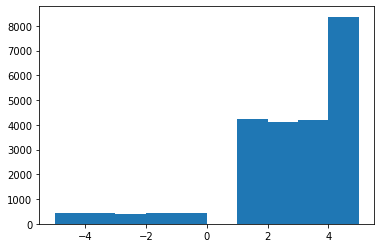

In [47]:
plt.hist(df_final["quantity"])

* At first glance, the boxplot doesn't show any outliers. Let's look at the distribution.

#### 'rate'

* Now let's look at ***'rate'***:


In [32]:
df_final['rate'].describe()

count    23040.000000
mean       637.094965
std        621.727374
min      -1499.000000
25%        312.000000
50%        710.000000
75%       1109.000000
max       1500.000000
Name: rate, dtype: float64

(array([ 495.,  444.,  460.,  407.,  358., 3413., 4335., 4336., 4349.,
        4443.]),
 array([-1.4990e+03, -1.1991e+03, -8.9920e+02, -5.9930e+02, -2.9940e+02,
         5.0000e-01,  3.0040e+02,  6.0030e+02,  9.0020e+02,  1.2001e+03,
         1.5000e+03]),
 <BarContainer object of 10 artists>)

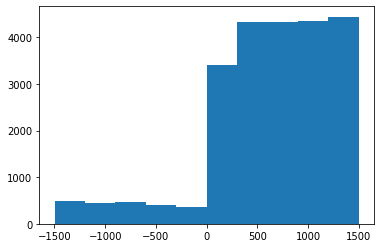

In [48]:
plt.hist(df_final["rate"])

In [ ]:
plt.hist(df_final["quantity"])

In [35]:
df_final['rate'].value_counts(normalize=True) * 100

 672     0.125868
 552     0.125868
 472     0.121528
 615     0.117188
 618     0.117188
           ...   
-1178    0.004340
-1114    0.004340
-1098    0.004340
-1034    0.004340
-80      0.004340
Name: rate, Length: 2551, dtype: float64

#### total_amt

(array([ 109.,  229.,  357.,  563.,  906., 9062., 5505., 3435., 1930.,
         944.]),
 array([-8270.925 , -6615.0825, -4959.24  , -3303.3975, -1647.555 ,
            8.2875,  1664.13  ,  3319.9725,  4975.815 ,  6631.6575,
         8287.5   ]),
 <BarContainer object of 10 artists>)

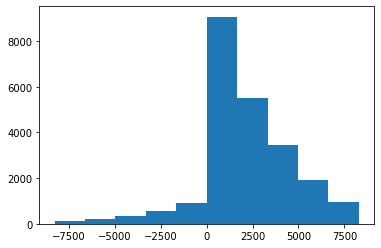

In [49]:
plt.hist(df_final["total_amt"])

#### city_code

(array([2255., 2268., 2410., 2422., 2357., 2127., 2356., 2328., 2176.,
        2333.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

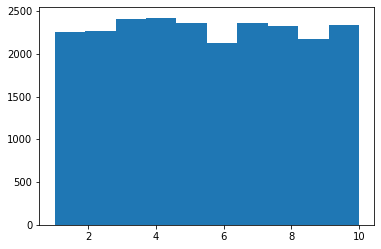

In [50]:
plt.hist(df_final["city_code"])

[Continue to the next part](02_Conclusion_and_Insight.ipynb)